# Whiteboard Test

Trying to understand the difference between defining the system based on EKE and MKE

In [2]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd
import scipy.ndimage as filter


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf

In [88]:
reload(df)
reload(ef)
reload(ff)
reload(pf);

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

In [4]:
l1 = 100
l2 = 200
l3 = 400
n = 100

MKE1 = ef.get_MV(float_z,l1,variable='SPICE')
MKE2 = ef.get_MV(float_z,l2,variable='SPICE')
MKE3 = ef.get_MV(float_z,l3,variable='SPICE')

EKE1 = ef.get_EV(float_z,l1,variable='SPICE')
EKE2 = ef.get_EV(float_z,l2,variable='SPICE')
EKE3 = ef.get_EV(float_z,l3,variable='SPICE')

In [5]:
MKE0_v = EKE1
MKE1_v = MKE1 - MKE2
MKE2_v = MKE2 - MKE3
MKE3_v = MKE3

EKE0_v = EKE1
EKE1_v = EKE2 - EKE1
EKE2_v = EKE3 - EKE2
EKE3_v = MKE3

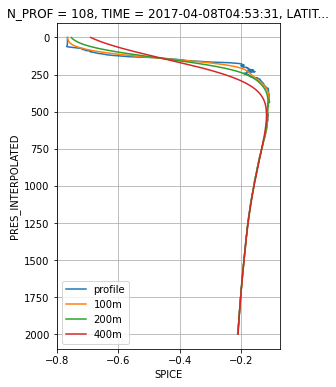

In [6]:
plt.figure(figsize=(4,6))

float_z.isel(N_PROF=n).SPICE.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l1),float_z.PRES_INTERPOLATED,label='{}m'.format(l1))
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l2),float_z.PRES_INTERPOLATED,label='{}m'.format(l2))
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l3),float_z.PRES_INTERPOLATED,label='{}m'.format(l3))

plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.savefig('profiles')

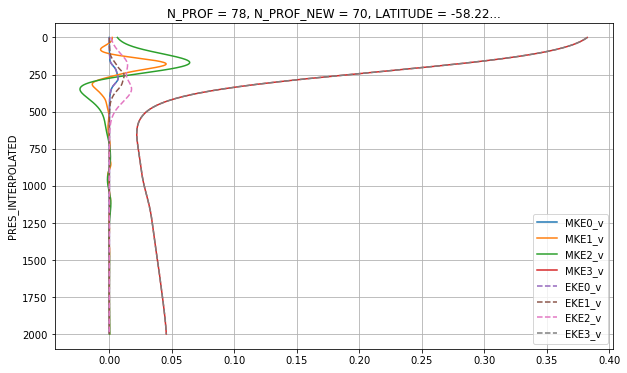

In [7]:
n = 70
plt.figure(figsize=(10,6))
MKE0_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE0_v')
MKE1_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE1_v')
MKE2_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE2_v')
MKE3_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE3_v')

EKE0_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0_v')
EKE1_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1_v')
EKE2_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2_v')
EKE3_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3_v')

plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.savefig('EKE,MKE')

This could be something that never came up in Stenberg because SSH is more constant, less sharp changes

## do cross terms cancel in EKE? I'd be forever grateful if they did :)

$MKE =         + <<u>>^2            + 2<<u>u'>          + <u'>^2$
$EKE = <<u>^2> - <<u>>^2 + <2<u>u'> - 2<<u>u'> + <u'^2> - <u'>^2$

$u = <u> + u'$

In [8]:
l1 = 2.
l2 = 3.

In [9]:
y = np.linspace(0,10*np.pi)
u = np.sin(y) + np.sin(y/3 + np.pi/9)

In [10]:
u_filt_l1 = filter.gaussian_filter1d(u, l1)
u_filt_l2 = filter.gaussian_filter1d(u, l2)

In [11]:
u_anom_l1 = u - u_filt_l1
u_anom_l2 = u - u_filt_l2

Text(0.5, 0, 'tracer values')

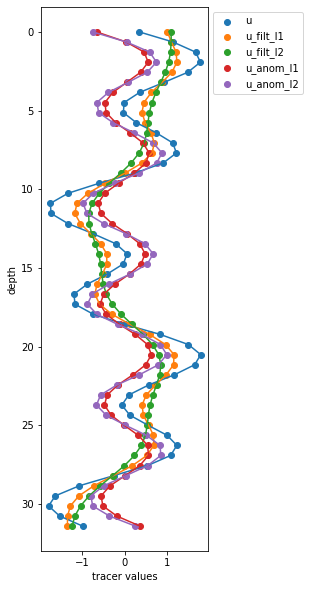

In [12]:
plt.figure(figsize=(3,10))
plt.scatter(u,y,label='u')
plt.scatter(u_filt_l1,y,label='u_filt_l1')
plt.scatter(u_filt_l2,y,label='u_filt_l2')
plt.scatter(u_anom_l1,y,label='u_anom_l1')
plt.scatter(u_anom_l2,y,label='u_anom_l2')
plt.plot(u,y)
plt.plot(u_filt_l1,y)
plt.plot(u_filt_l2,y)
plt.plot(u_anom_l1,y)
plt.plot(u_anom_l2,y)
plt.legend(bbox_to_anchor=(1,1))
plt.gca().invert_yaxis()
plt.ylabel('depth')
plt.xlabel('tracer values')

In [13]:
MKE_1 = filter.gaussian_filter1d(u, l1,  )**2
EKE_1 = filter.gaussian_filter1d(u**2, l1) - MKE_1

In [14]:
MKE_2 = filter.gaussian_filter1d((u_filt_l1 + u_anom_l1),   l1)**2
EKE_2 = filter.gaussian_filter1d((u_filt_l1 + u_anom_l1)**2,l1) - MKE_2

In [15]:
term_1 = filter.gaussian_filter1d(u_filt_l1**2,        l1)
term_2 = filter.gaussian_filter1d(u_filt_l1*u_anom_l1, l1)*2
term_3 = filter.gaussian_filter1d(u_anom_l1**2,        l1)
term_4 = filter.gaussian_filter1d(u_filt_l1,           l1)**2
term_5 = filter.gaussian_filter1d(u_filt_l1,           l1)*2*filter.gaussian_filter1d(u_anom_l1,l1)
term_6 = filter.gaussian_filter1d(u_anom_l1,           l1)**2

In [16]:
MKE_3 =                            term_4 + term_5 + term_6
EKE_3 = term_1 + term_2 + term_3 - term_4 - term_5 - term_6

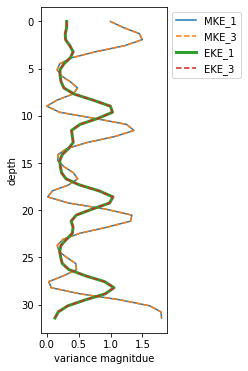

In [17]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.plot(MKE_1,y,label='MKE_1')
plt.plot(MKE_3,y,label='MKE_3',linestyle='--')
plt.plot(EKE_1,y,label='EKE_1',linewidth='3')
plt.plot(EKE_3,y,label='EKE_3',linestyle='--')
#plt.plot(term_1,y,'--',label='1')
#plt.plot(term_2,y,'--',label='2')
#plt.plot(term_3,y,'--',label='3')
#plt.plot(term_4,y,'--',label='4')
#plt.plot(term_5,y,'--',label='5')
#plt.plot(term_6,y,'--',label='6')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('depth')
plt.xlabel('variance magnitdue')
plt.gca().invert_yaxis()

plt.subplots_adjust(wspace=0.65)

The methods match up! This means that the 6 terms have been calculated correctly and their influence on the profiles can be examined fairly. The next step is to perform a similar analysis with a binned system to make sure all terms for those equations have also been calculated correctly.

In [ ]:
EKE0_1 = filter.gaussian_filter1d(u**2,l1) - filter.gaussian_filter1d(u,l1)**2
MKE1_1 = filter.gaussian_filter1d(u,l1)**2 - filter.gaussian_filter1d(u,l2)**2
EKE1_1 = filter.gaussian_filter1d(u**2,l2) - filter.gaussian_filter1d(u,l2)**2 - filter.gaussian_filter1d(u**2,l1) + filter.gaussian_filter1d(u,l1)**2
MKE2_1 = filter.gaussian_filter1d(u,l2)**2

In [25]:
term1  = filter.gaussian_filter1d(u_filt_l2**2,       l2)
term2  = filter.gaussian_filter1d(u_filt_l2*u_anom_l2,l2)*2
term3  = filter.gaussian_filter1d(u_anom_l2**2,       l2)
term4  = filter.gaussian_filter1d(u_filt_l2,          l2)**2
term5  = filter.gaussian_filter1d(u_filt_l2,          l2)*2*filter.gaussian_filter1d(u_anom_l2,l2)
term6  = filter.gaussian_filter1d(u_anom_l2,          l2)**2

term7  = filter.gaussian_filter1d(u_filt_l1**2,       l1)
term8  = filter.gaussian_filter1d(u_filt_l1*u_anom_l1,l1)*2
term9  = filter.gaussian_filter1d(u_anom_l1**2,       l1)
term10 = filter.gaussian_filter1d(u_filt_l1,          l1)**2
term11 = filter.gaussian_filter1d(u_filt_l1,          l1)*2*filter.gaussian_filter1d(u_anom_l1,l1)
term12 = filter.gaussian_filter1d(u_anom_l1,          l1)**2

In [26]:
EKE0_2 =                                                 term7 + term8 + term9 - term10 - term11 - term12
EKE1_2 = term1 + term2 + term3 - term4 - term5 - term6 - term7 - term8 - term9 + term10 + term11 + term12
MKE1_2 =                       - term4 - term5 - term6                         + term10 + term11 + term12
MKE2_2 =                         term4 + term5 + term6

Text(0.5, 1.0, 'MKE2')

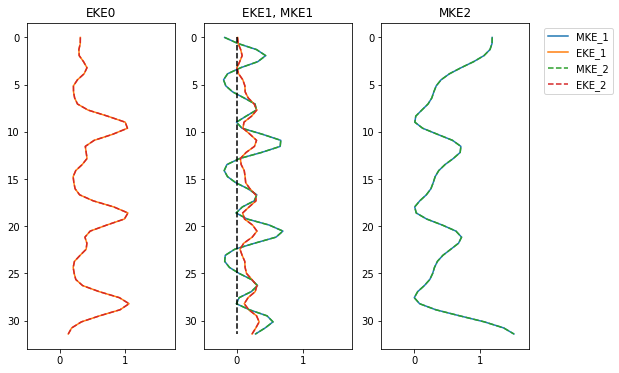

In [37]:
plt.figure(figsize=(9,6))

plt.subplot(1,3,1)
plt.plot(EKE0_1,y,color='tab:orange')
plt.plot(EKE0_2,y,'--',color='tab:red')
#plt.plot(term7,y,'--',label='term2',color='tab:orange')
#plt.plot(term8,y,'--',label='term4',color='tab:red')
#plt.plot(term9,y,'--',label='term6',color='tab:brown')
#plt.plot(term10,y,'--',label='term8',color='tab:gray')
#plt.plot(term11,y,'--',label='term10',color='tab:cyan')
#plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange')
plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('EKE0')

plt.subplot(1,3,2)
plt.plot(MKE1_1,y,label='MKE_1')
plt.plot(EKE1_1,y,label='EKE_1')
plt.plot(MKE1_2,y,'--',label='MKE_2')
plt.plot(EKE1_2,y,'--',label='EKE_2')
plt.vlines(0,0,10*np.pi,linestyle='--',color='k')
#plt.plot(term1,y,'--',label='term1',color='tab:blue')
#plt.plot(term2,y,'--',label='term2',color='tab:orange')
#plt.plot(term3,y,'--',label='term3',color='tab:green')
#plt.plot(term4,y,'--',label='term4',color='tab:red')
#plt.plot(term5,y,'--',label='term5',color='tab:purple')
#plt.plot(term6,y,'--',label='term6',color='tab:brown')
#plt.plot(term7,y,'--',label='term7',color='tab:pink')
#plt.plot(term8,y,'--',label='term8',color='tab:gray')
#plt.plot(term9,y,'--',label='term9',color='tab:olive')
#plt.plot(term10,y,'--',label='term10',color='tab:cyan')
#plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue')
#plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange')
plt.legend(bbox_to_anchor=(2.8,1))
plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('EKE1, MKE1')

plt.subplot(1,3,3)
plt.plot(MKE2_1,y,color='tab:blue')
plt.plot(MKE2_2,y,'--',color='tab:green')
#plt.plot(term4,y,'--',label='term3',color='tab:green')
#plt.plot(term5,y,'--',label='term7',color='tab:pink')
#plt.plot(term61,y,linestyle='dashdot',label='term11',color='tab:blue')
plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('MKE2')

In [35]:
print(EKE1.sum(), MKE1.sum())

8.039893646961511 8.039893646961511


This also works which means that all 12 terms have been calculated correctly. Also it's good news that the total variance is the same across depth for both of these methods, it means that the only difference should be how they're distributed (namely that the EKE method minimizes the amount of negative values for variance).

Text(0.5, 1.0, 'MKE1')

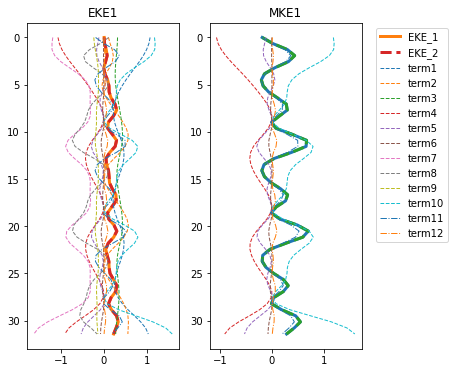

In [49]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.plot(EKE1_1,y,label='EKE_1',color='tab:orange',linewidth=3)
plt.plot(EKE1_2,y,'--',label='EKE_2',color='tab:red',linewidth=3)
plt.plot(term1,y,'--',label='term1',color='tab:blue',linewidth=1)
plt.plot(term2,y,'--',label='term2',color='tab:orange',linewidth=1)
plt.plot(term3,y,'--',label='term3',color='tab:green',linewidth=1)
plt.plot(-term4,y,'--',label='term4',color='tab:red',linewidth=1)
plt.plot(-term5,y,'--',label='term5',color='tab:purple',linewidth=1)
plt.plot(-term6,y,'--',label='term6',color='tab:brown',linewidth=1)
plt.plot(-term7,y,'--',label='term7',color='tab:pink',linewidth=1)
plt.plot(-term8,y,'--',label='term8',color='tab:gray',linewidth=1)
plt.plot(-term9,y,'--',label='term9',color='tab:olive',linewidth=1)
plt.plot(term10,y,'--',label='term10',color='tab:cyan',linewidth=1)
plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue',linewidth=1)
plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange',linewidth=1)
plt.legend(bbox_to_anchor=(2.8,1))
#plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('EKE1')

plt.subplot(1,2,2)
plt.plot(MKE1_1,y,label='MKE_1',color='tab:blue',linewidth=3)
plt.plot(MKE1_2,y,'--',label='MKE_2',color='tab:green',linewidth=3)
plt.plot(-term4,y,'--',label='term4',color='tab:red',linewidth=1)
plt.plot(-term5,y,'--',label='term5',color='tab:purple',linewidth=1)
plt.plot(-term6,y,'--',label='term6',color='tab:brown',linewidth=1)
plt.plot(term10,y,'--',label='term10',color='tab:cyan',linewidth=1)
plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue',linewidth=1)
plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange',linewidth=1)
#plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('MKE1')

## Function for Calculating EKE

This function will calculate EKE by the binning approach and return a dataset with the binned values as variables. I think it's only necessary to do this for EKE (and not MKE) because right now, only the ratios use MKE, and even then it's the total values not the binned ones. 

It's also worth noting that this will not help with plotting ratios because the partition ratio uses total values. If this is something that you end up using fairly frequently, it's probably worth making a new function. If not, calculate it on a case-by-case basis in each notebook.

In [4]:
box = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-20,-10)_lat:(35,45)_ds_z.nc')

In [5]:
def get_EKE_ds(ds, scales, variable):
    
    #everything here is dependent on the number of scales. If there's only 2, it will return 3 bins. 
    #If there's 10, it will return 11. 
    #I think this means everything needs to be in a loop that iterates through the list scales?
    #but I'm not sure how this would separate that the first and last bins are calculated differently from middle ones
    #much to think through
    
    for n in range(0,len(scales)+1):
        
        if n==0:
            eke1 = ef.get_EV(ds,scales[0],variable=variable)
            
        if n>0 and n<len(scales):
            print('mid box {}-{}'.format(scales[n-1],scales[n]))
            
        if n==len(scales):
            print('last box >{}'.format(scales[n-1]))
            
    return

In [7]:
l1, l2, l3, l4, l5, l6 = 50, 100, 200, 400, 600, 1000

In [201]:
get_EKE_ds(box, [l1, l2])

first box <50
mid box 50-100
last box >100


In [202]:
get_EKE_ds(box, [l1, l2, l3])

first box <50
mid box 50-100
mid box 100-200
last box >200


In [203]:
get_EKE_ds(box, [l1, l2, l3, l4, l5, l6])

first box <50
mid box 50-100
mid box 100-200
mid box 200-400
mid box 400-600
mid box 600-1000
last box >1000


In [207]:
def get_EKE_ds(ds, scales, sample_max, variable):
    
    ds = ds.where(ds.sample_rate<sample_max).dropna('N_PROF')
    ekes_li = []
    
    for n in range(0,len(scales)):
        ekes_li.append(ef.get_EV(ds,scales[n],variable=variable))

    EKES_li = []
    for n in range(0,len(scales)+1):

        if n==0:
            EKES_li.append((ekes_li[n]).drop_vars('mask',errors='ignore').drop_vars('N_PROF_NEW',errors='ignore'))

        elif n>0 and n<len(scales):
            EKES_li.append((ekes_li[n] - ekes_li[n-1]).drop_vars('mask',errors='ignore').drop_vars('N_PROF_NEW',errors='ignore'))
    
    EKE_da = xr.concat(EKES_li, dim='EKE')
    EKE_da = EKE_da.assign_coords(mask=(['N_PROF','PRES_INTERPOLATED'], ekes_li[-1].mask.data))
    
    return EKE_da

In [208]:
EKE_da = get_EKE_ds(box, [l1, l2, l3, l4, l5], sample_max=6, variable='SPICE')

In [209]:
EKE_da

<xarray.DataArray (EKE: 5, N_PROF: 860, PRES_INTERPOLATED: 900)>
array([[[ 1.89209943e-04,  3.42877745e-04,  5.91463814e-04, ...,
          3.80994802e-05,  3.21429747e-05,  2.66464443e-05],
        [ 2.47814257e-05,  3.14048986e-05,  3.92105356e-05, ...,
          2.24497355e-05,  1.59083693e-05,  1.11253537e-05],
        [ 2.61980776e-06,  2.68109648e-06,  2.68432012e-06, ...,
          2.35819245e-04,  2.01506776e-04,  1.68457976e-04],
        ...,
        [ 9.29245172e-03,  1.27846594e-02,  1.73134815e-02, ...,
          9.96346148e-05,  8.84678285e-05,  7.73555373e-05],
        [ 9.45545329e-03,  1.13286676e-02,  1.35446629e-02, ...,
          3.05379549e-04,  2.68598984e-04,  2.32813864e-04],
        [ 1.06077611e-02,  1.45614900e-02,  1.96901859e-02, ...,
          2.13549602e-05,  1.66502291e-05,  1.29594354e-05]],

       [[ 5.75118049e-02,  6.66323581e-02,  7.67682108e-02, ...,
          1.25143585e-04,  1.16983468e-04,  1.09079301e-04],
        [ 1.64650415e-04,  1.79356480e-04,  1.94424621e-04, ...,
          1.71646457e-04,  1.59468891e-04,  1.46521519e-04],
        [-5.18538457e-07, -3.70638311e-07,  5.29656489e-07, ...,
          2.21865973e-04,  2.32895305e-04,  2.41673371e-04],
...
        [ 3.05095853e-01,  2.99163558e-01,  2.93215952e-01, ...,
          7.80506635e-03,  7.63024240e-03,  7.45798592e-03],
        [ 3.60024932e-01,  3.56898541e-01,  3.53668933e-01, ...,
          2.56439243e-02,  2.51239449e-02,  2.46102585e-02],
        [ 6.81018103e-01,  6.69524842e-01,  6.57779161e-01, ...,
          3.98643030e-03,  3.90342507e-03,  3.82211484e-03]],

       [[ 3.18906856e-01,  3.17146426e-01,  3.15407486e-01, ...,
          6.97729843e-03,  6.87919757e-03,  6.78201152e-03],
        [ 1.95400831e-01,  1.96579755e-01,  1.97715753e-01, ...,
          7.97036996e-03,  7.87478455e-03,  7.77967600e-03],
        [ 1.43140393e-01,  1.44205724e-01,  1.45247743e-01, ...,
          9.67248231e-03,  9.51267168e-03,  9.35471665e-03],
        ...,
        [ 1.84130390e-01,  1.81699703e-01,  1.79332578e-01, ...,
          2.25164299e-02,  2.21787972e-02,  2.18441985e-02],
        [ 2.44587671e-01,  2.42324550e-01,  2.40090225e-01, ...,
          6.30847602e-02,  6.22845177e-02,  6.14878444e-02],
        [ 4.22760549e-01,  4.17690548e-01,  4.12720772e-01, ...,
          1.42458845e-02,  1.39958502e-02,  1.37492224e-02]]])
Coordinates:
  * N_PROF             (N_PROF) int64 1253 1254 1255 1256 ... 8623 9417 8562
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1792 1794 1796 1798
    LATITUDE           (N_PROF) float64 35.14 35.25 35.65 ... 42.29 38.9 38.61
    LONGITUDE          (N_PROF) float64 -19.77 -17.1 -16.95 ... -10.71 -19.15
    month              (N_PROF) int64 9 12 1 1 1 2 4 5 5 5 ... 7 7 7 7 7 7 7 7 8
    month_frac         (N_PROF) float64 9.715 12.96 1.278 ... 7.862 8.026 8.127
    year               (N_PROF) int64 2013 2013 2014 2014 ... 2023 2023 2023
    year_frac          (N_PROF) float64 2.014e+03 2.014e+03 ... 2.024e+03
    MLD                (N_PROF) int64 46 118 118 122 174 214 ... 12 8 28 10 4 18
    TIME               (N_PROF) datetime64[ns] 2013-09-21T10:42:59 ... 2023-0...
    mask               (N_PROF, PRES_INTERPOLATED) float64 0.0 0.0 ... 0.0 0.0
Dimensions without coordinates: EKE

# Validate EKE Function

In [161]:
sample_max=6
box_samp = box.where(box.sample_rate<sample_max).dropna('N_PROF')

eke1 = ef.get_EV(box_samp,l1,'SPICE')
eke2 = ef.get_EV(box_samp,l2,'SPICE')
eke3 = ef.get_EV(box_samp,l3,'SPICE')
eke4 = ef.get_EV(box_samp,l4,'SPICE')
eke5 = ef.get_EV(box_samp,l5,'SPICE')

In [184]:
EKE1 = eke1
EKE2 = eke2 - eke1
EKE3 = eke3 - eke2
EKE4 = eke4 - eke3
EKE5 = eke5 - eke4

Text(0.5, 1.0, '')

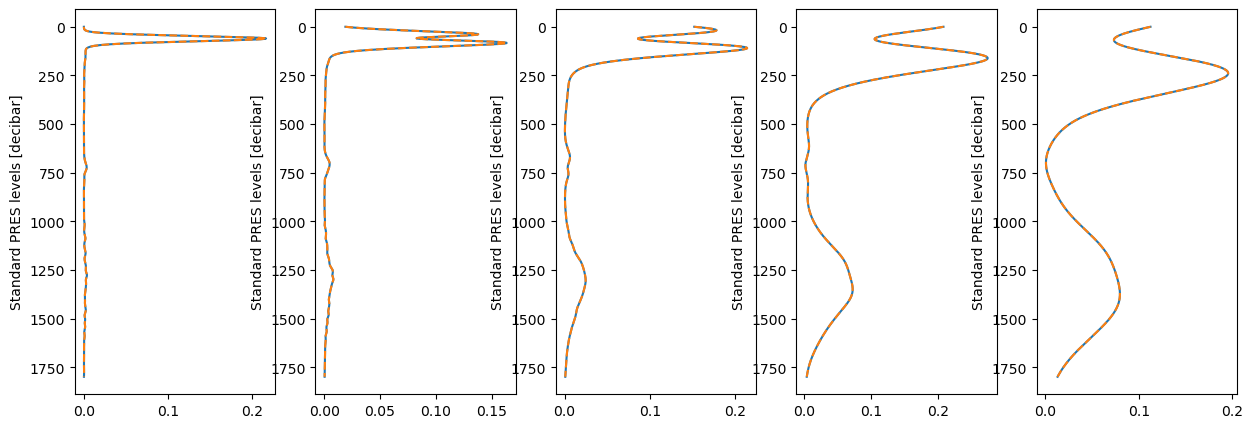

In [186]:
plt.figure(figsize=(15,5))
prof=np.random.randint(0,len(EKE0.N_PROF))

plt.subplot(151)
EKE1.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED')
EKE_da.isel(EKE=0).isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',linestyle='--')
plt.gca().invert_yaxis()
plt.title('')

plt.subplot(152)
EKE2.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED')
EKE_da.isel(EKE=1).isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',linestyle='--')
plt.gca().invert_yaxis()
plt.title('')

plt.subplot(153)
EKE3.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED')
EKE_da.isel(EKE=2).isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',linestyle='--')
plt.gca().invert_yaxis()
plt.title('')

plt.subplot(154)
EKE4.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED')
EKE_da.isel(EKE=3).isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',linestyle='--')
plt.gca().invert_yaxis()
plt.title('')

plt.subplot(155)
EKE5.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED')
EKE_da.isel(EKE=4).isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',linestyle='--')
plt.gca().invert_yaxis()
plt.title('')

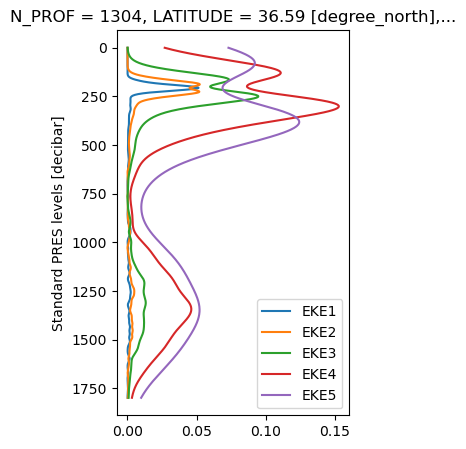

In [187]:
plt.figure(figsize=(3,5))
prof=np.random.randint(0,len(EKE0.N_PROF))
EKE1.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',label='EKE1')
EKE2.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',label='EKE2')
EKE3.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',label='EKE3')
EKE4.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',label='EKE4')
EKE5.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',label='EKE5')
#EKE5.isel(N_PROF=prof).plot(y='PRES_INTERPOLATED',label='EKE5')
plt.legend()
plt.gca().invert_yaxis()